In [187]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import time
import random

### Questions:
calculate p(k)

\<L\>, \<C\> , C(k) distribution of C
    
: rewire network with probability \beta, and recalculate \<L\>, \<C\>, C(k) (distributioin of C)
    
: centrality metrics: degree, betweenness
    
: Investigate the effect of removing high degree nodes and high BC nodes if GCC of the network
    
:perform a community detection using the modularity algorithm and compute the value of Q of the network. Report a plot of the network colored by modules Report the adj matrix according to the modules.
    
: calculate k_nn vs k: is network asort. or disassort.
    
: display network using gephi.
    
: The jupyter notebook MUST contain explanations of the flow of the work.


 ### Results:

The network I used is an undirected network of co-authorship graph around Paul Erdős, obtained from here:
http://konect.cc/networks/pajek-erdos/

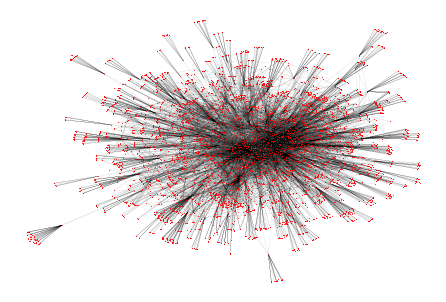

In [288]:
path_file = 'erdos.txt'
edge_list = pd.read_csv(path_file, delimiter = '\t', names = ['source', 'target'])

G = nx.Graph()
G = nx.read_edgelist(path_file)

options = {
    "node_color": "red",
    "node_size": 1,
    "linewidths": 0,
    "width": 0.05,
}
nx.draw(G, **options)

Finding p(k):

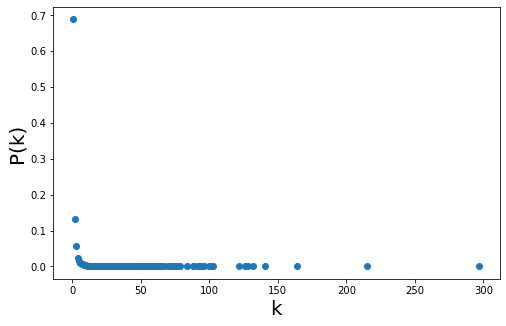

In [23]:
degrees = G.degree
degrees = list(dict(degrees).values())
degree_sequence_nx=[d for n,d in G.degree()]

bins=np.arange(0.5,max(np.unique(degrees)),1)
counts_nx, bins=np.histogram(degree_sequence_nx,bins=bins)

x=(bins[1:]-bins[:-1])/2 +bins[:-1]

plt.figure(figsize=(8,5))
plt.plot(x[counts_nx!=0],counts_nx[counts_nx!=0]/sum(counts_nx[counts_nx!=0]),'o')
plt.ylabel('P(k)', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

and the CDF of the degree distribution:

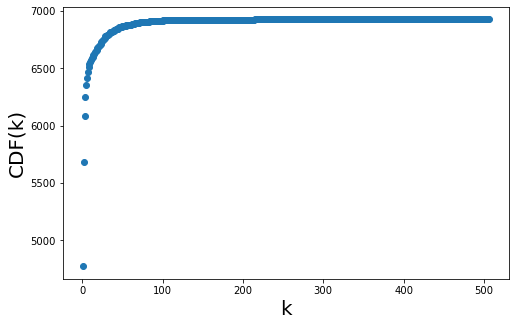

In [25]:
cfd_emp = np.cumsum(counts_nx)

plt.figure(figsize=(8,5))
plt.plot(x,cfd_emp,'o')
plt.ylabel('CDF(k)', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

Using log scale:

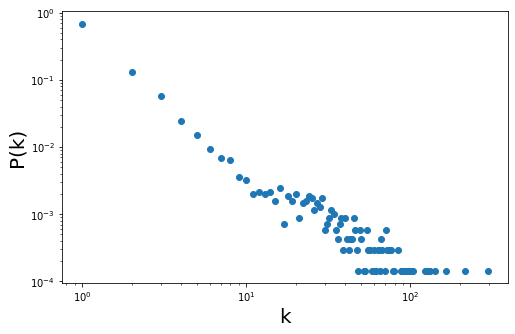

In [24]:
plt.figure(figsize=(8,5))
plt.loglog(x[counts_nx!=0],counts_nx[counts_nx!=0]/sum(counts_nx[counts_nx!=0]),'o')
plt.ylabel('P(k)', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

L is the average shortest path in a network and is computed as follows:

In [10]:
start=time.time()
L = nx.average_shortest_path_length(G)
print(L)
print(time.time()-start)

Now we find thre clustering coefficient of each node, and their average:

In [70]:
clustering_nodes = nx.clustering(G)
C_ave=nx.average_clustering(G)

Text(0.5, 1.0, '<C> = 0.12390011501874706')

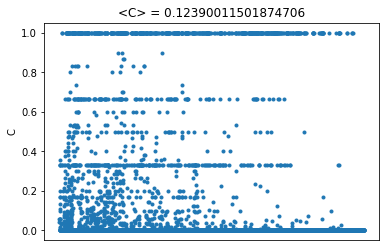

In [22]:
plt.plot(list(clustering_nodes.values()),'.')
plt.ylabel('C', fontsize=10)
plt.xticks([])
plt.title('<C> = ' + str(C_ave))

The distribution of clustering coefficients is as follows:

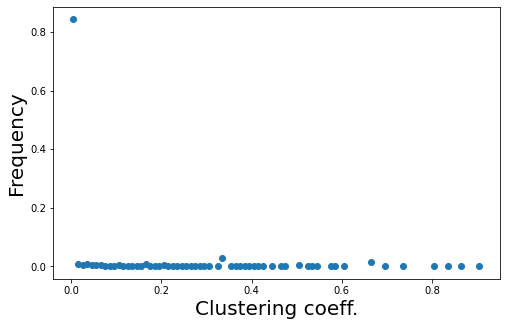

In [96]:
bins=np.arange(0.0,1,.01)
counts_nx, bins=np.histogram(list(clustering_nodes.values()),bins=bins)

x=(bins[1:]-bins[:-1])/2 +bins[:-1]

plt.figure(figsize=(8,5))
plt.plot(x[counts_nx!=0],counts_nx[counts_nx!=0]/sum(counts_nx[counts_nx!=0]),'o')
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Clustering coeff.',fontsize=20)
#plt.yscale("log")
plt.show()

The above was the frwquency of occurance of various Clustering Coefficients. Here we plot C(k), i.e. the clustering coefficient as a function of the degree of each node, as a scatter plot:

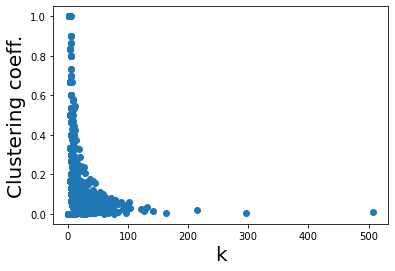

In [98]:
degrees = list(dict(G.degree).values())
x=np.asarray(degrees)

clustering_seq=list(clustering_nodes.values())
y=np.asarray(clustering_seq)

plt.scatter(x, y)
plt.ylabel('Clustering coeff.', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

We then calcuate the average of the clustering coefficient as a function of node degree. 

In [169]:
N_nodes = len((list(clustering_nodes.values())))
data = np.zeros((N_nodes,2)) # first column is clustering coef. of a node and 2nd column is its degree
data[:,0] = list(clustering_nodes.values())
data[:,1] = list(dict(G.degree).values())

In [165]:
uniqdegs = np.unique(list(dict(G.degree).values()))
data2 = np.zeros((len(uniqdegs),2)) # first col.= total clustering coef. of the nodes with degree k, 2nd col. = number of them
for idx, deg in enumerate(uniqdegs):
    for node in range(N_nodes):
        if data[node,1] == deg:
            data2[idx,0] = data2[idx,0] + data[node,0]
            data2[idx,1] += 1

freq = np.divide(data2[:,0], data2[:,1]+1)

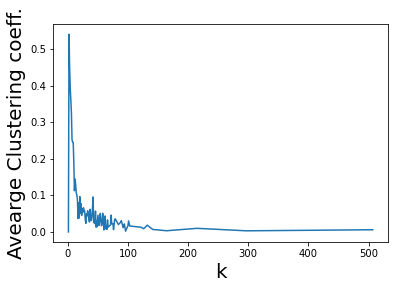

In [167]:
plt.plot(uniqdegs, freq)
plt.ylabel('Avearge Clustering coeff.', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

We see that clustering coef. for k=1 is zero which is expected. We therefore start k from 2:

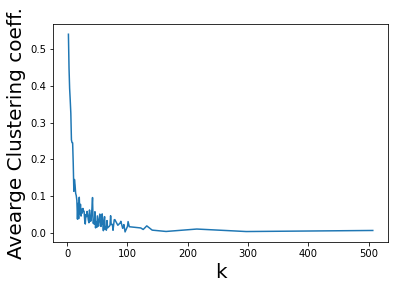

In [174]:
plt.plot(uniqdegs[1:], freq[1:])
plt.ylabel('Avearge Clustering coeff.', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

We now rewire the network with a probaility beta and repeat the above steps. First we need to define a function that rewires our network (found online here: https://greenteapress.com/complexity2/html/thinkcomplexity2004.html):

In [404]:
def flip(p):
    return np.random.random() < p #returns true with probability p and false with probability 1-p
def rewire(G, p): #p=beta is probability of rewiring a new edge
    nodes = set(G)
    for u,v in G.edges(): #enumerate edges and use flip to decide which ones are rewired
        if flip(p):
            #to compute possible choices, start with set nodes and subtract source node u and its neighbors to avoid self loops and multiple edges
            choices = nodes - {u} - set(G[u])
            #select random choice of node from remaining options
            new_v = np.random.choice(list(choices))
            #remove old edge
            G.remove_edge(u,v)
            #create new edge
            G.add_edge(u,new_v)
    return G

First we see the its effect on average clustering coefficient:

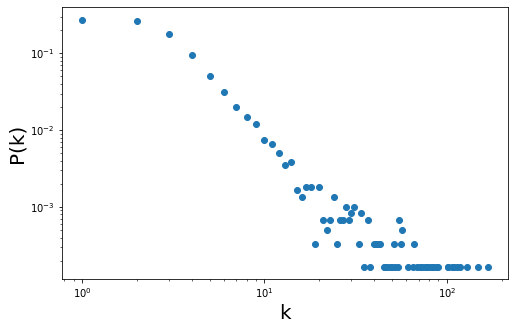

In [409]:
G2 = rewire(G, 0.8)
degrees2 = G2.degree
degrees2 = list(dict(degrees2).values())
degree_sequence_nx2=[d for n,d in G2.degree()]

bins2=np.arange(0.5,max(np.unique(degrees2)),1)
counts_nx2, bins2=np.histogram(degree_sequence_nx2,bins=bins2)

x=(bins2[1:]-bins2[:-1])/2 +bins2[:-1]

plt.figure(figsize=(8,5))
plt.loglog(x[counts_nx2!=0],counts_nx2[counts_nx2!=0]/sum(counts_nx2[counts_nx2!=0]),'o')
plt.ylabel('P(k)', fontsize=20)
plt.xlabel('k',fontsize=20)
plt.show()

### Centrality metrics

In [334]:
start=time.time()

degree_cent = nx.degree_centrality(G)
G_bet = nx.betweenness_centrality(G, normalized=True)

print(time.time()-start)

186.71014952659607


Drawing the network with the node size proportional to the BC of it:

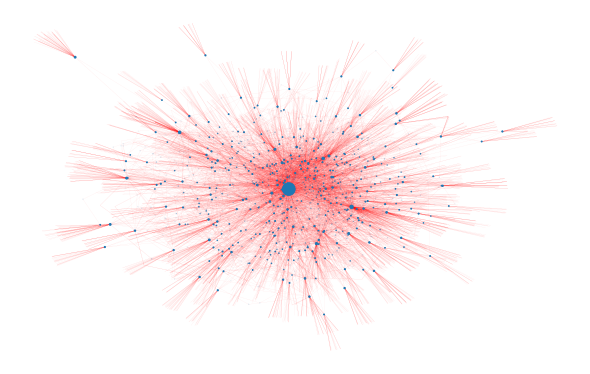

In [286]:
plt.figure(figsize=(8,5))
nx.draw(G, pos, node_size=[G_bet[key] * 200 for key in G_bet.keys()], edge_color='r',
        with_labels=False, width= 0.02)

The largest BC node is node 6927 with BC = 0.8 :

In [337]:
Keymax = max(G_bet, key=G_bet.get)
G_bet[Keymax]

0.8070044981260268

and the next largest is node 186:

In [340]:
G_bet_tmp = G_bet.copy()
G_bet_tmp[Keymax] = 0
Keymax2 = max(G_bet_tmp, key = G_bet_tmp.get)
G_bet[Keymax2]

0.057947436227666314

This is the scatter plot of the BC of all nodes (x axis is log scale):

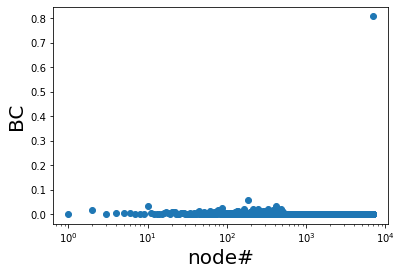

In [345]:
X  = np.zeros([N_nodes,2])
idx = 0
for k, v in G_bet.items():
    X[idx,0] = k
    X[idx,1] = v
    idx +=1

plt.scatter(X[:,0], X[:,1])
plt.ylabel('BC', fontsize=20)
plt.xlabel('node#',fontsize=20)
plt.xscale("log")
#plt.yscale("log")
plt.show()

And plotting this for degree centrality:

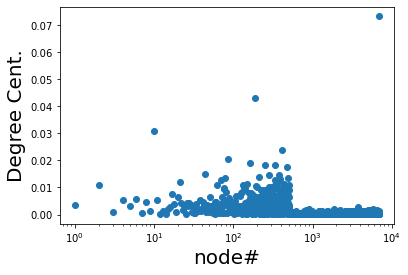

In [351]:
X  = np.zeros([N_nodes,2])
idx = 0
for k, v in degree_cent.items():
    X[idx,0] = k
    X[idx,1] = v
    idx +=1

plt.scatter(X[:,0], X[:,1])
plt.ylabel('Degree Cent.', fontsize=20)
plt.xlabel('node#',fontsize=20)
plt.xscale("log")
#plt.yscale("log")
plt.show()

And the two largest degree centrality nodes are the same as largest BC nodes:

In [355]:
Keymax_dc = max(degree_cent, key=degree_cent.get)
degree_cent[Keymax_dc]
Keymax_dc

'6927'

In [356]:
degree_cent_tmp = degree_cent.copy()
degree_cent_tmp[Keymax] = 0
Keymax2_dc = max(degree_cent_tmp, key = degree_cent_tmp.get)
degree_cent[Keymax2_dc]
Keymax2_dc

'186'

Now we remove node 6927. We first make a copy of G and modify that copy:

In [358]:
G2 = G.copy()
G2.remove_node(Keymax_dc)

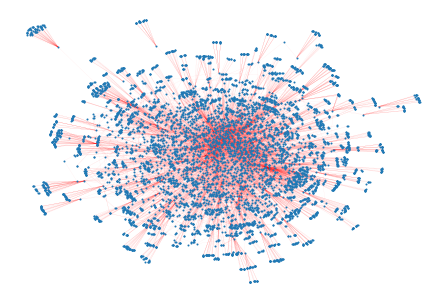

In [360]:
nx.draw(G2, pos, edge_color='r',node_size = 1,
        with_labels=False, width= 0.02)

We can see that it's not connected anymore:

In [361]:
print(nx.is_connected(G2))

False


So we take its GCC:

In [365]:
Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

In [366]:
nx.draw(G2, pos, edge_color='r',node_size = 1,
        with_labels=False, width= 0.02)

True


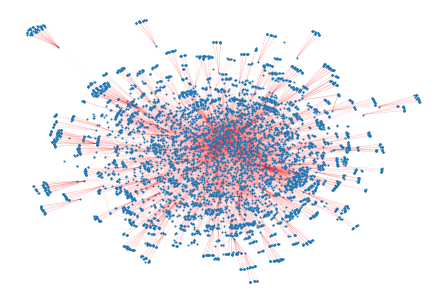

In [368]:
nx.draw(G0, pos, edge_color='r',node_size = 1,
        with_labels=False, width= 0.02)

Using Clauset-Newman-Moore greedy modularity maximization algorithm, we find the communities:

In [370]:
from networkx.algorithms.community import greedy_modularity_communities

start=time.time()
c = list(greedy_modularity_communities(G))
print(time.time() - start)

16.057763814926147


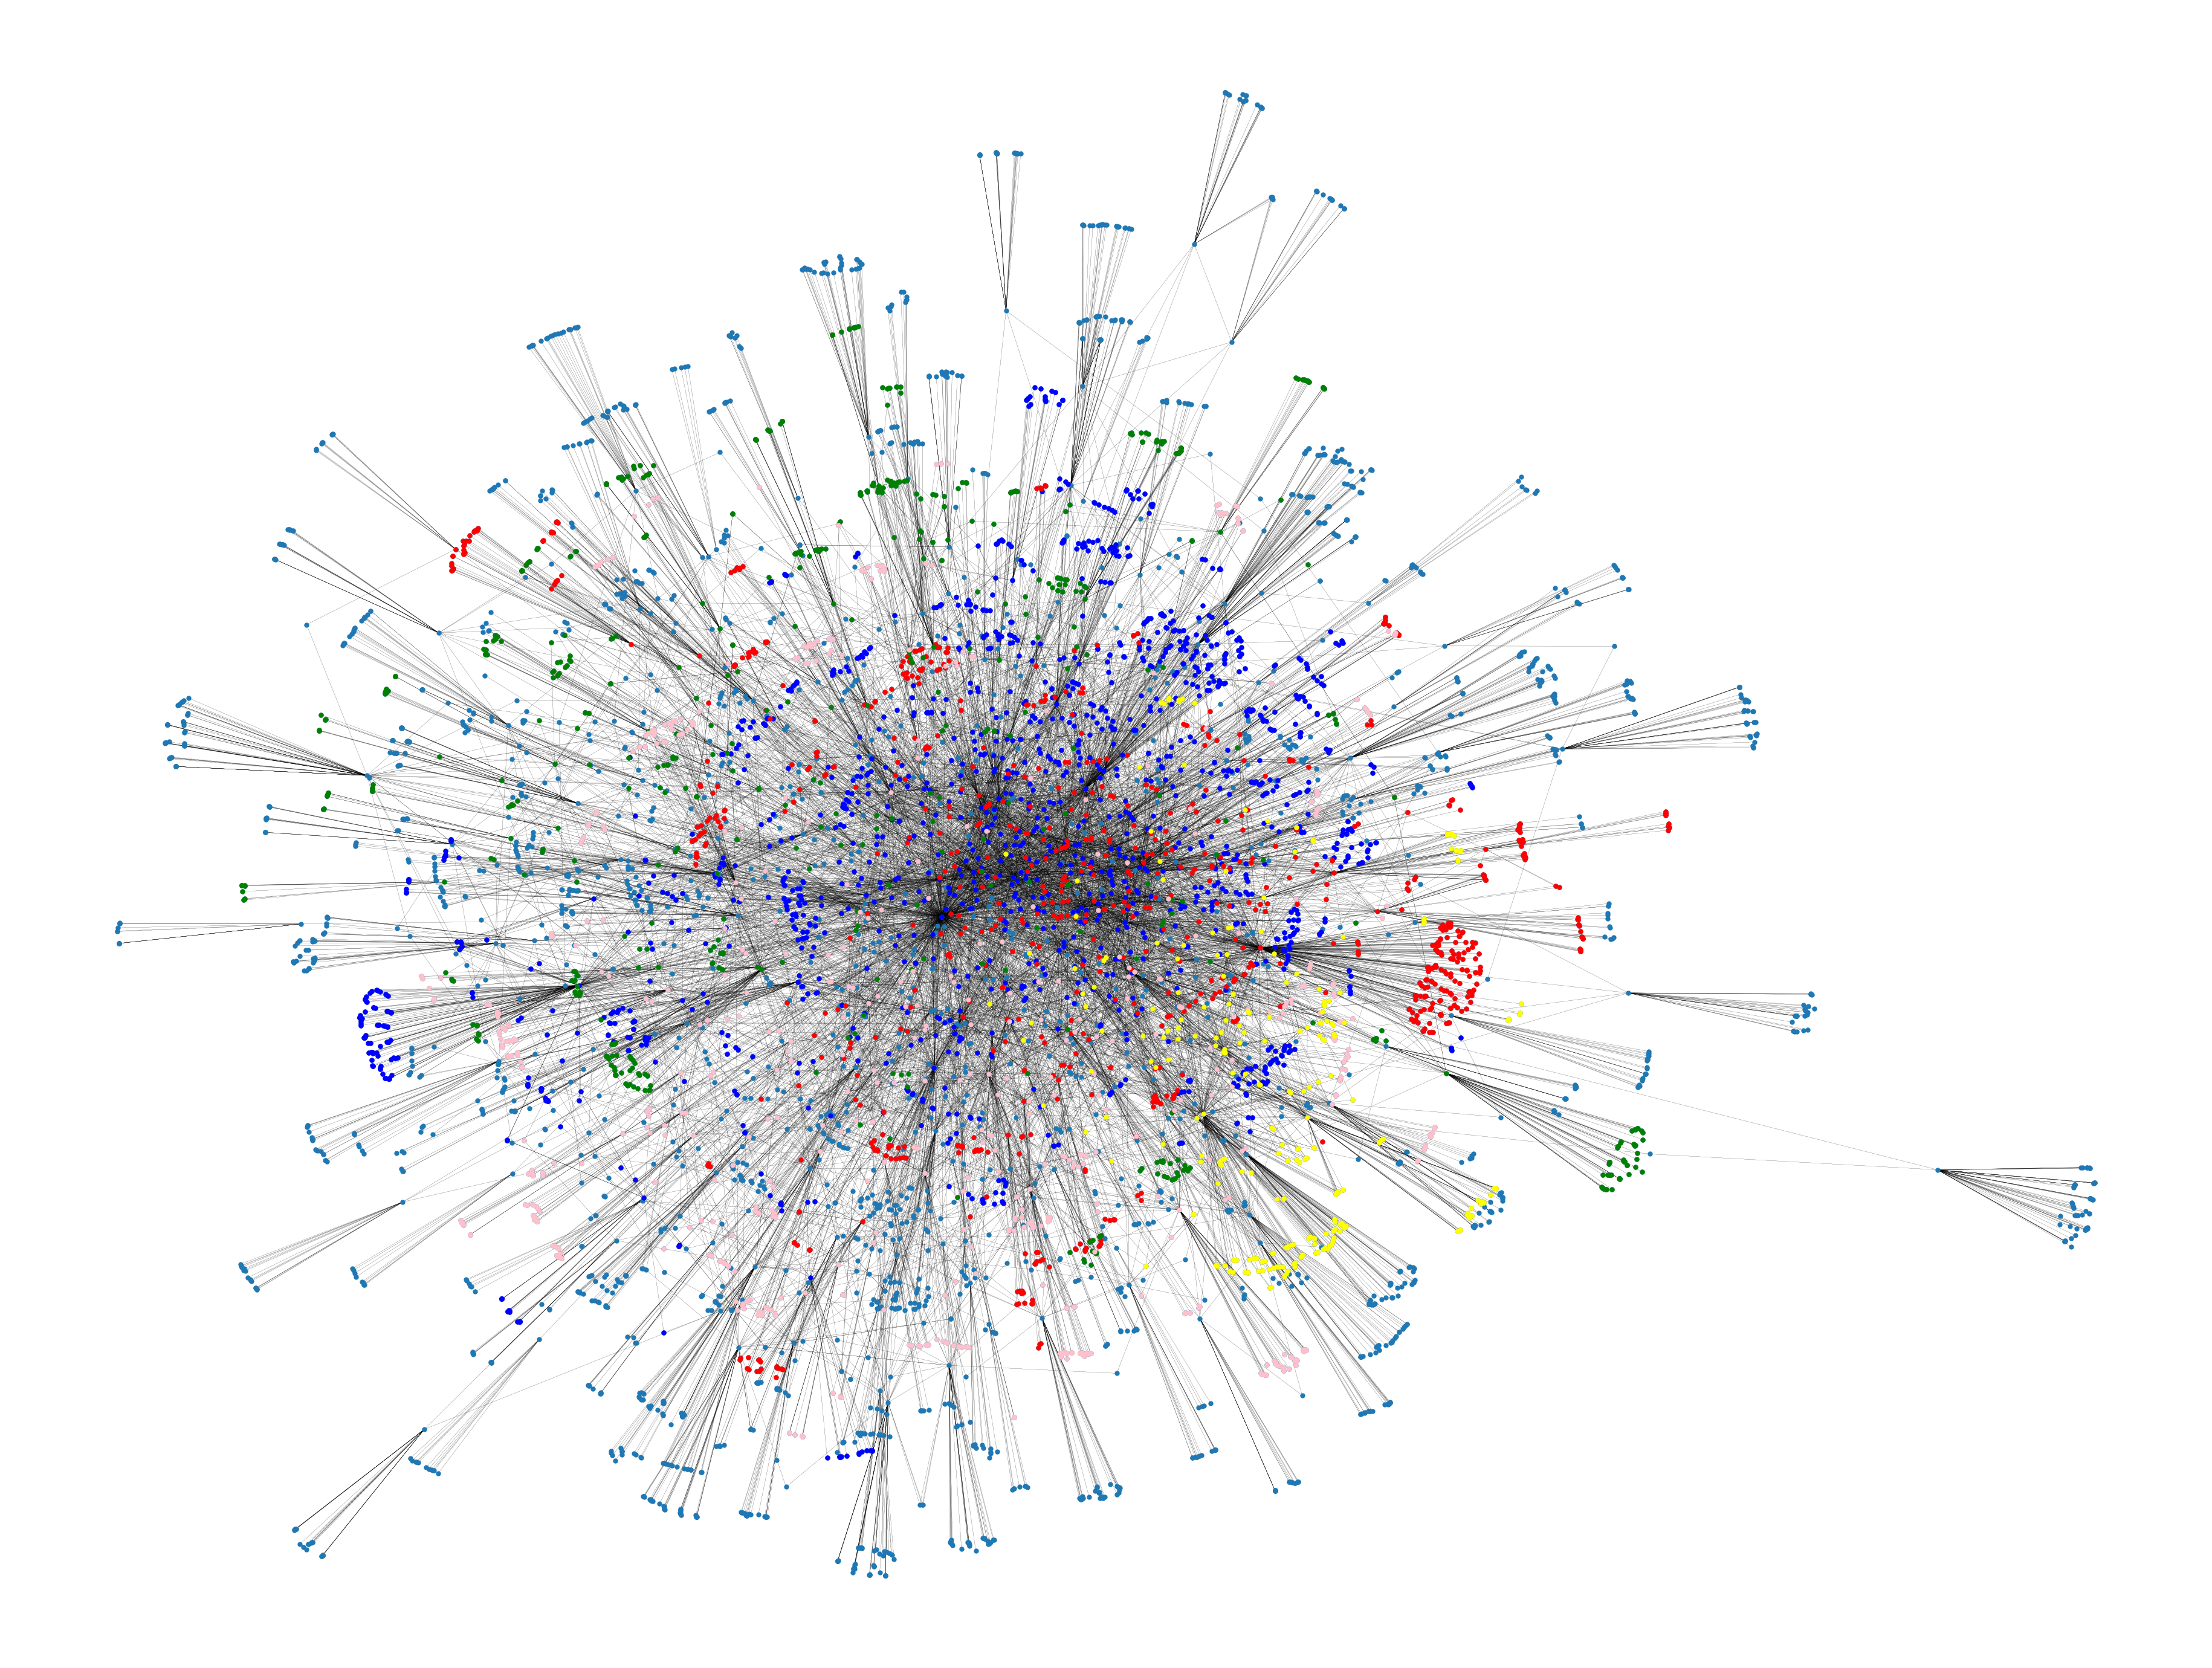

In [380]:
pos = nx.spring_layout(G)


plt.figure(figsize=(12,9), dpi = 300)
nx.draw(G, pos, edge_color='k',  node_size= 1, width= 0.05)

nx.draw_networkx_nodes(G, pos,node_size= 1, nodelist=c[0], node_color='b', width= 0.05)
nx.draw_networkx_nodes(G, pos,node_size= 1, nodelist=c[1], node_color='r', width= 0.05)
nx.draw_networkx_nodes(G, pos,node_size= 1, nodelist=c[2], node_color='g', width= 0.05)
nx.draw_networkx_nodes(G, pos,node_size= 1, nodelist=c[3], node_color='pink', width= 0.05)
nx.draw_networkx_nodes(G, pos,node_size= 1, nodelist=c[4], node_color='yellow', width= 0.05)
plt.show()

Since the network is very large and sparse, plotting its adjacency matrix is not realy helpful:

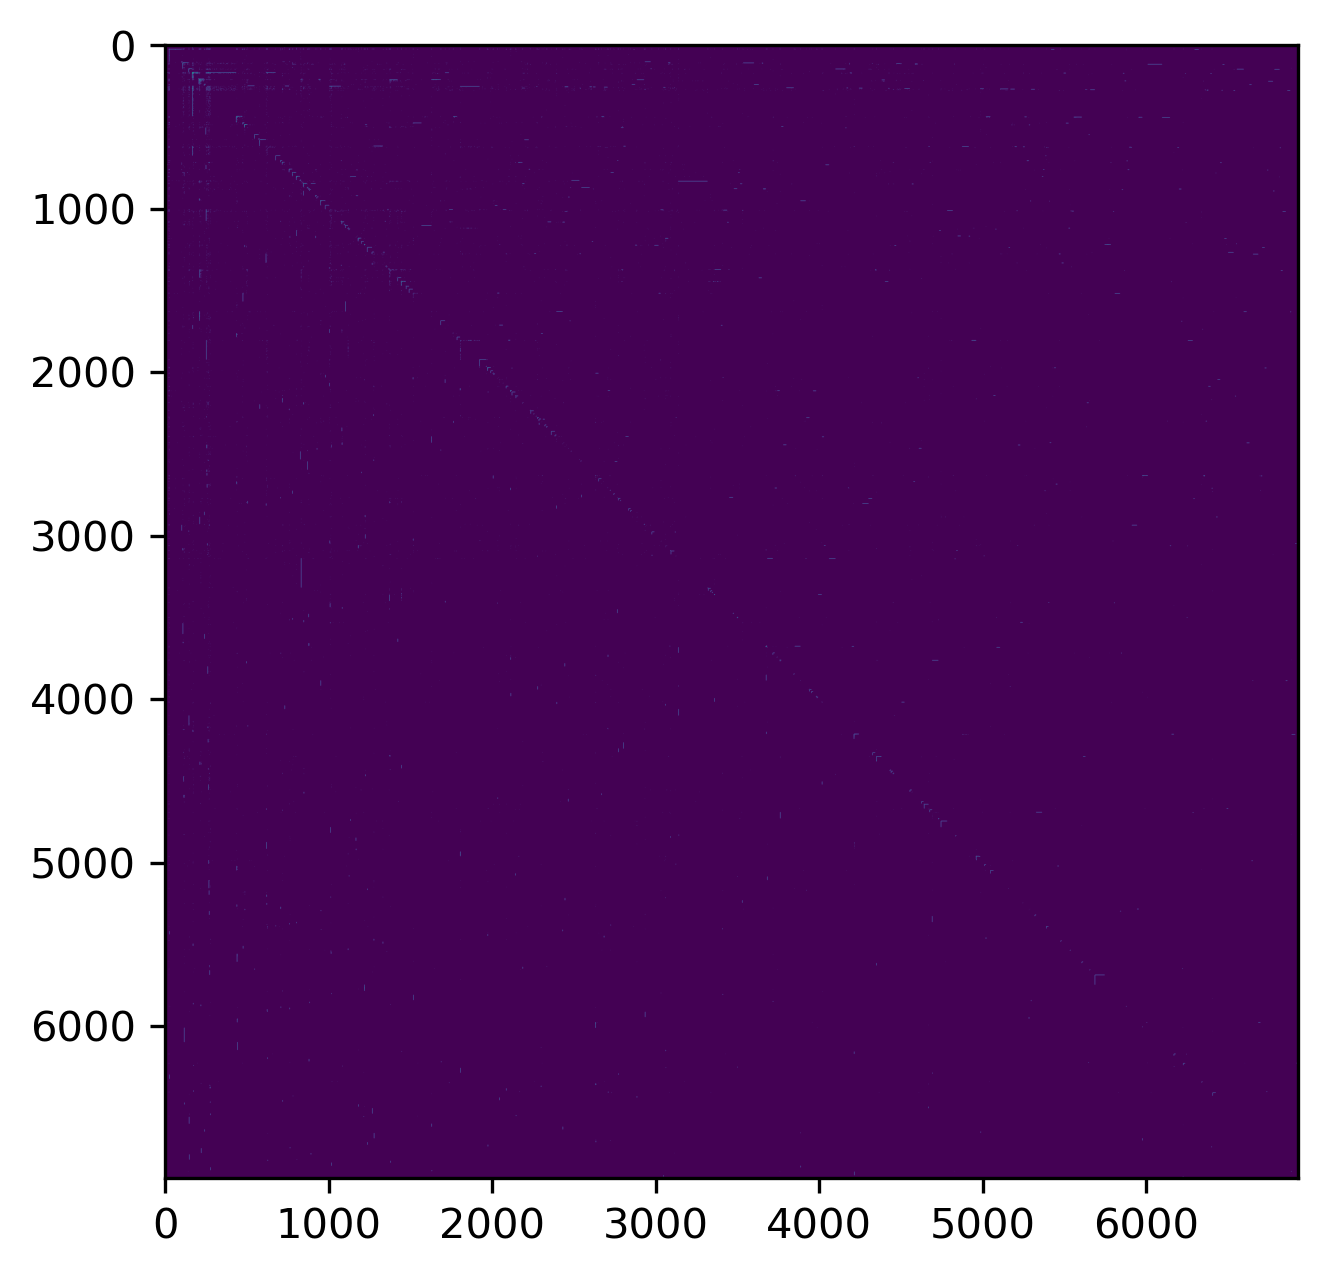

In [382]:
plt.figure(figsize=(8,5), dpi = 300)
plt.imshow(nx.to_numpy_array(G))
plt.show()

### Assortativity vs Disassortativity

We now find 

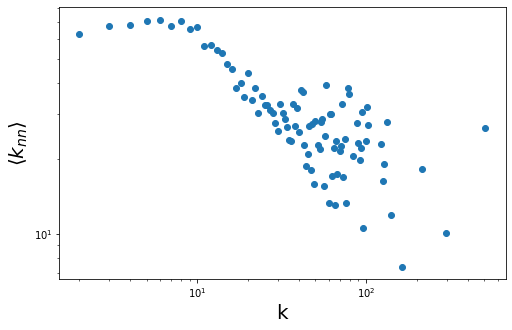

In [392]:
#compute the average neighbour degree and the degree
avg_degree = nx.average_neighbor_degree(G)
degree = G.degree

x = []
y = []
for key in avg_degree.keys():
    x.append(degree[key])
    y.append(avg_degree[key])
    

avg_y=[]
y=np.array(y)
for i in np.unique(x):
     avg_y.append(np.mean(y[x==i]))
        
        
plt.figure(figsize=(8,5))

plt.plot(np.unique(x)[1:],avg_y[1:], marker="o", ls="None")
plt.xlabel("k",fontsize=20)
plt.ylabel(r"$\langle k_{nn} \rangle$",fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.show()

So we can see that the network (coauthorship network) is disassortative.

Exporting the network to Gephi:

In [393]:
nx.write_gexf(G, "Erdos.gexf")

Displaying it Gephi using ForceAtlas2 layout:

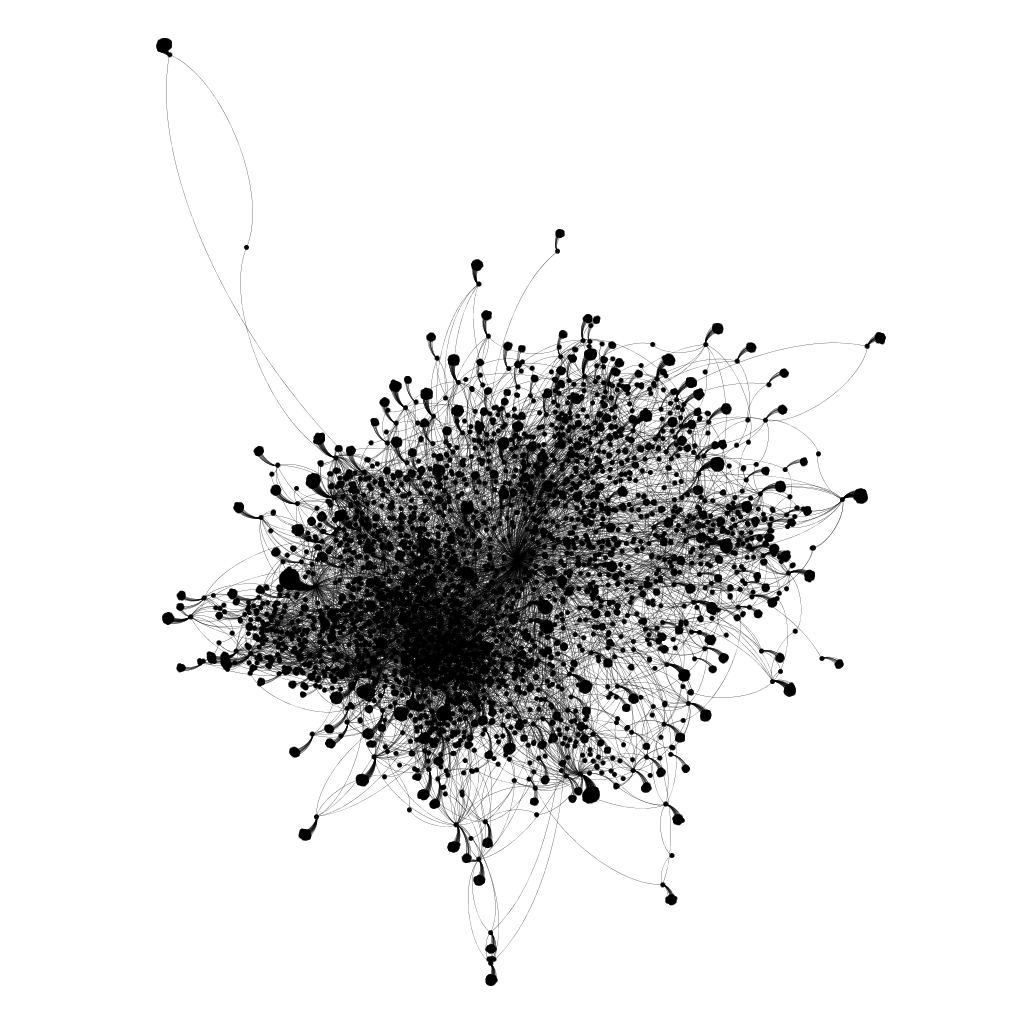

In [410]:
from IPython.display import Image
Image(filename='graph.PNG') 